# Setup

In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load dataset into variable

In [2]:
import pandas as pd

def load_asteroid_data():
    #csv_path = "shuffled_asteroids_head.csv"
    csv_path = "combined.csv"
    return pd.read_csv(csv_path, low_memory=False)

# Removing unneeded features and null features

In [3]:
asteroids = load_asteroid_data()
#asteroids.head()
asteroids = asteroids.dropna(subset=['pha'])
asteroids = asteroids.dropna(subset=['sigma_e'])
asteroids = asteroids.dropna(subset=['neo'])
asteroids = asteroids.dropna(subset=['H'])
asteroids = asteroids.dropna(subset=['ma'])
asteroids = asteroids.drop(columns=['spkid', 'full_name', 'pdes', 'prefix', 'name', 'orbit_id', 'equinox', 'diameter', "diameter_sigma", "albedo"])
asteroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10027 entries, 0 to 10026
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10027 non-null  object 
 1   neo        10027 non-null  object 
 2   pha        10027 non-null  object 
 3   H          10027 non-null  float64
 4   epoch      10027 non-null  float64
 5   epoch_mjd  10027 non-null  int64  
 6   epoch_cal  10027 non-null  float64
 7   e          10027 non-null  float64
 8   a          10027 non-null  float64
 9   q          10027 non-null  float64
 10  i          10027 non-null  float64
 11  om         10027 non-null  float64
 12  w          10027 non-null  float64
 13  ma         10027 non-null  float64
 14  ad         10027 non-null  float64
 15  n          10027 non-null  float64
 16  tp         10027 non-null  float64
 17  tp_cal     10027 non-null  float64
 18  per        10027 non-null  float64
 19  per_y      10027 non-null  float64
 20  moid  

# Converting object datatypes to numerical and standardizing data

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder()

#splitting features into numerical and categorical
asteroids_num = asteroids.drop(columns=["id", "neo", "pha", "class"])
asteroids_id = asteroids[["id"]]
asteroids_cat = asteroids[["neo", "pha", "class"]]

#encode categorical features
asteroid_cat_encoded = ordinal_encoder.fit_transform(asteroids_cat)

#Normalizing numerical features
std_scaler = StandardScaler()
asteroid_num_scaled = std_scaler.fit_transform(asteroids_num)

    

# Creating features and labels 

In [5]:
X = np.concatenate((asteroid_cat_encoded, asteroid_num_scaled), axis=1)
X = np.delete(X, 2, 1)
y = asteroid_cat_encoded[:,2]

print(X.shape)
print(y.shape)

(10027, 33)
(10027,)


# Encoded Features

In [6]:
# Print the shape of the dataset
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Print the first 5 rows of the encoded and scaled features
print("First 5 rows of encoded and scaled features:")
print(X[:5, :])  # Adjust the number of rows as needed

# If you want to see the corresponding original values for comparison:
print("\nFirst 5 rows of original categorical features:")
print(asteroids_cat.head())  # Assuming asteroids_cat has the original categorical data

print("\nFirst 5 rows of original numerical features:")
print(asteroids_num.head())  # Assuming asteroids_num has the original 


Shape of X: (10027, 33)
Shape of y: (10027,)
First 5 rows of encoded and scaled features:
[[ 1.00000000e+00  1.00000000e+00  1.29673614e+00  1.03929223e-01
   1.03929223e-01  1.03995726e-01  2.31920199e+00 -4.92661587e-01
  -1.59988625e+00  1.34806429e+00 -9.21906249e-01 -6.17202834e-01
  -3.57483218e-01  5.87423315e-01  8.88026015e-02 -5.39107911e-01
  -3.86925034e-01 -4.04479899e-01 -4.04479899e-01 -1.42187069e+00
  -1.42187069e+00 -2.10763836e-02 -1.88192184e-02 -1.74815949e-02
  -1.49328072e-02 -2.12572595e-02 -1.70694683e-02 -1.79954534e-02
  -1.91978427e-02 -2.03856698e-02 -1.63499702e-02 -1.87938453e-02
  -8.11536226e-01]
 [ 0.00000000e+00  0.00000000e+00 -5.03767731e-01  1.03929223e-01
   1.03929223e-01  1.03995726e-01 -5.61953246e-01  3.10915130e-01
   5.27056485e-01 -8.00627968e-01  6.74581191e-01  5.86429353e-01
  -8.34517863e-01  3.70866815e-02 -4.07424830e-01 -4.95254348e-01
  -3.81919403e-01  1.87759647e-01  1.87759647e-01  5.23204599e-01
   5.23204599e-01 -2.10768444e-02

# Training and test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Classification

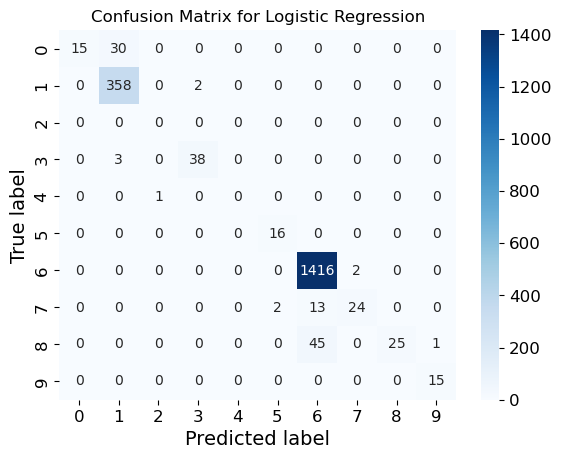

Accuracy:  0.9506480558325024
Micro F1 scorre:  0.9506480558325024
Macro F1 score:  0.6539133467541507
RMSE:  0.3586281605331876
MAE:  0.07577268195413758


In [8]:
from sklearn.linear_model import LogisticRegression

def logistic_regression():
    # Initialization and fitting logisitic regression
    log_reg = LogisticRegression(solver="newton-cg", random_state=42)
    log_reg.fit(X_train, y_train)

    #Make predictions
    y_pred = log_reg.predict(X_test)

    #Model metrics
    log_reg_accuracy = accuracy_score(y_test, y_pred)
    log_reg_microf1 = f1_score(y_test, y_pred, average="micro")
    log_reg_macrof1 = f1_score(y_test, y_pred, average="macro")
    # Calculate RMSE and MAE
    log_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    log_reg_mae = mean_absolute_error(y_test, y_pred)

    cm_log_reg = confusion_matrix(y_test, y_pred)

    # Plotting
    sns.heatmap(cm_log_reg, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix for Logistic Regression")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

    return log_reg, log_reg_accuracy, log_reg_microf1, log_reg_macrof1, log_reg_rmse, log_reg_mae

log_reg, log_reg_accuracy, log_reg_microf1, log_reg_macrof1, log_reg_rmse, log_reg_mae = logistic_regression()

print("Accuracy: ", log_reg_accuracy)
print("Micro F1 scorre: ", log_reg_microf1)
print("Macro F1 score: ", log_reg_macrof1)
print("RMSE: ", log_reg_rmse)
print("MAE: ", log_reg_mae)

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
def randomForest():
    rndFr = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
    rndFr.fit(X_train, y_train)
    y_pred_rf = rndFr.predict(X_test)
    rndFr_accuracy = accuracy_score(y_test, y_pred_rf)
    rndFr_microf1 = f1_score(y_test, y_pred_rf, average="micro")
    rndFr_macrof1 = f1_score(y_test, y_pred_rf, average="macro")
    rndFr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    rndFr_mae = mean_absolute_error(y_test, y_pred_rf)
    return rndFr, rndFr_accuracy, rndFr_microf1, rndFr_macrof1, rndFr_rmse, rndFr_mae

rndFr, rndFr_accuracy, rndFr_microf1, rndFr_macrof1, rndFr_rmse, rndFr_mae = randomForest()

print("Accuracy: ", rndFr_accuracy)
print("Micro F1 scorre: ", rndFr_microf1)
print("Macro F1 score: ", rndFr_macrof1)
print("RMSE: ", rndFr_rmse)
print("MAE: ", rndFr_mae)

Accuracy:  0.9835493519441675
Micro F1 scorre:  0.9835493519441675
Macro F1 score:  0.8244815821560008
RMSE:  0.15468747639656608
MAE:  0.01794616151545364


# Multi Layer Perceptron

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

def MLP():

    learning_rate = 0.01
    optimizer = Adam(learning_rate=learning_rate)
    
    # Define the MLP
    model = keras.models.Sequential([
        keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    # Train the model
    history = model.fit(X_train, y_train, epochs=75, batch_size=32,
                        validation_data=(X_test, y_test))

    # Evaluate the model
    model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred.round(2)

    # Calculate scores
    mlp_accuracy = accuracy_score(y_test, y_pred)
    mlp_microf1 = f1_score(y_test, y_pred, average="micro")
    mlp_macrof1 = f1_score(y_test, y_pred, average="macro")
    mlp_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlp_mae = mean_absolute_error(y_test, y_pred)

    return model, history, mlp_accuracy, mlp_microf1, mlp_macrof1, mlp_rmse, mlp_mae

mlp_model, mlp_history, mlp_accuracy, mlp_microf1, mlp_macrof1, mlp_rmse, mlp_mae = MLP()

print("MLP Test Accuracy:", mlp_accuracy)
print("MLP Micro F1 Score:", mlp_microf1)
print("MLP Macro F1 Score:", mlp_macrof1)
print("RMSE: ", mlp_rmse)
print("MAE: ", mlp_mae)

2023-12-03 20:07:50.291111: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 20:07:50.292476: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 20:07:50.316204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 20:07:50.316229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 20:07:50.316896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/75
251/251 [==============================] - 1s 2ms/step - loss: -126650515456.0000 - accuracy: 0.1789 - val_loss: -907883053056.0000 - val_accuracy: 0.1795
Epoch 2/75
251/251 [==============================] - 0s 1ms/step - loss: -15765918973952.0000 - accuracy: 0.1798 - val_loss: -51431851687936.0000 - val_accuracy: 0.1795
Epoch 3/75
251/251 [==============================] - 0s 1ms/step - loss: -207432408104960.0000 - accuracy: 0.1798 - val_loss: -451512933285888.0000 - val_accuracy: 0.1795
Epoch 4/75
251/251 [==============================] - 0s 1ms/step - loss: -1078862096105472.0000 - accuracy: 0.1798 - val_loss: -1890992496050176.0000 - val_accuracy: 0.1795
Epoch 5/75
251/251 [==============================] - 0s 1ms/step - loss: -3647728877830144.0000 - accuracy: 0.1798 - val_loss: -5593777754341376.0000 - val_accuracy: 0.1795
Epoch 6/75
251/251 [==============================] - 0s 1ms/step - loss: -9443081526968320.0000 - accuracy: 0.1798 - val_loss: -132242891299880

# XGBOOST

In [11]:
import xgboost as xgb

def xgboost_clf():
    # Initialize XGBoost
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Train the model
    xgb_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_clf.predict(X_test)

    # Model metrics
    xgb_accuracy = accuracy_score(y_test, y_pred)
    xgb_microf1 = f1_score(y_test, y_pred, average="micro")
    xgb_macrof1 = f1_score(y_test, y_pred, average="macro")
    xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    xgb_mae = mean_absolute_error(y_test, y_pred)

    return xgb_clf, xgb_accuracy, xgb_microf1, xgb_macrof1, xgb_rmse, xgb_mae

xgb_model, xgb_accuracy, xgb_microf1, xgb_macrof1, xgb_rmse, xgb_mae = xgboost_clf()

print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Micro F1 Score:", xgb_microf1)
print("XGBoost Macro F1 Score:", xgb_macrof1)
print("RMSE: ", xgb_rmse)
print("MAE: ", xgb_mae)


XGBoost Accuracy: 0.9925224327018943
XGBoost Micro F1 Score: 0.9925224327018943
XGBoost Macro F1 Score: 0.8677746762929767
RMSE:  0.15944820103582016
MAE:  0.012462612163509471
